# Exploring the SVHN Data

### Importing neccessary libraries

In [1]:

import numpy as np
import scipy.io as sio
from typing import List, Tuple

import torch
import torchvision
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### Loading the test and training data

In [2]:
shiftTransform = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(degrees=0,translate=(0.08,0.08)),
    torchvision.transforms.ToTensor()
    ])

In [3]:
train = torchvision.datasets.SVHN(root="data/", split="train", transform=shiftTransform)
test = torchvision.datasets.SVHN(root="data/", split="test", transform=torchvision.transforms.ToTensor())

small_train = Subset(train, range(0, 1000))
small_test = Subset(test, range(0, 1000))

### Preparing out data set

In [4]:
n_epochs = 15
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = DataLoader(train, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size_test, shuffle=True)

small_train_loader = DataLoader(small_train, batch_size=batch_size_train, shuffle=True)
small_test_loader = DataLoader(small_test, batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

torch.Size([1000, 3, 32, 32])

In [5]:
# 6 layer Net (3 convolutional layers, 1 dropout layer, 2 linear layers)

# TODO : remove pooling... this might mean the inputs of some of the layers will need to be altered...
#        This will most likely mean editing the x = x.view() line to resize the data such that there 
#        will be a (1000,N) shape
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv3 = nn.Conv2d(20, 30, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(14520, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2_drop(self.conv3(x)), 2)  # can't pool because image will be too small
        x = x.view(-1, 14520)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [6]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [7]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [8]:
def train(network: Net, optimizer, epoch: int, train_data: DataLoader, train_losses: List | None = None, train_counter: List | None = None):
  network.train()
  for batch_idx, (data, target) in enumerate(train_data):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_data.dataset),
        100. * batch_idx / len(train_data), loss.item()))
      if train_losses is not None and train_counter is not None:
        train_losses.append(loss.item())
        train_counter.append(
          (batch_idx*64) + ((epoch-1)*len(train_data.dataset)))
    #torch.save(network.state_dict(), '/results/model.pth')
    #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [9]:
def test(network: Net, test_data: DataLoader, test_losses: List | None = None) -> (float, float):
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_data:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_data.dataset)
  if test_losses is not None:
    test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_data.dataset),
    100. * correct / len(test_data.dataset)))
  return (correct / len(test_data.dataset), test_loss)

In [10]:
print(example_data.shape)
test(network, test_loader, test_losses)
for epoch in range(1, n_epochs + 1):
  train(network, optimizer, 
        epoch, train_loader, train_losses, train_counter)
  test(network, test_loader, test_losses)

torch.Size([1000, 3, 32, 32])


C:\Users\nawor\AppData\Local\Temp\ipykernel_31424\607711756.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
c:\Users\nawor\miniconda3\envs\cs178\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.2931, Accuracy: 5099/26032 (20%)

Train Epoch: 1 [0/73257 (0%)]	Loss: 2.266840
Train Epoch: 1 [640/73257 (1%)]	Loss: 2.285555
Train Epoch: 1 [1280/73257 (2%)]	Loss: 2.256680
Train Epoch: 1 [1920/73257 (3%)]	Loss: 2.256995
Train Epoch: 1 [2560/73257 (3%)]	Loss: 2.199718
Train Epoch: 1 [3200/73257 (4%)]	Loss: 2.259709
Train Epoch: 1 [3840/73257 (5%)]	Loss: 2.266203
Train Epoch: 1 [4480/73257 (6%)]	Loss: 2.282422
Train Epoch: 1 [5120/73257 (7%)]	Loss: 2.194581
Train Epoch: 1 [5760/73257 (8%)]	Loss: 2.265530
Train Epoch: 1 [6400/73257 (9%)]	Loss: 2.274297
Train Epoch: 1 [7040/73257 (10%)]	Loss: 2.239635
Train Epoch: 1 [7680/73257 (10%)]	Loss: 2.214262
Train Epoch: 1 [8320/73257 (11%)]	Loss: 2.249514
Train Epoch: 1 [8960/73257 (12%)]	Loss: 2.254393
Train Epoch: 1 [9600/73257 (13%)]	Loss: 2.292958
Train Epoch: 1 [10240/73257 (14%)]	Loss: 2.251459
Train Epoch: 1 [10880/73257 (15%)]	Loss: 2.298986
Train Epoch: 1 [11520/73257 (16%)]	Loss: 2.197918
Train Epoch: 1 [12160/7

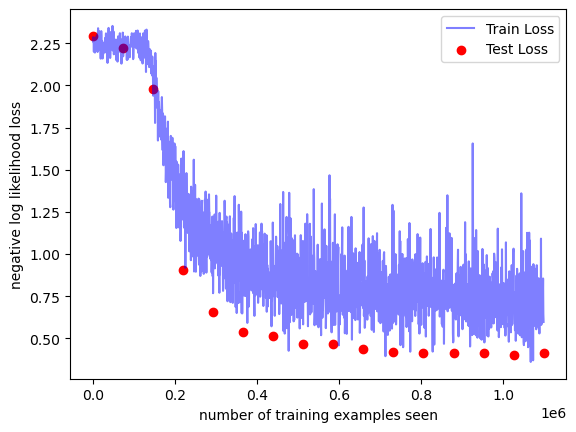

In [11]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue', alpha=0.5)
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig
plt.show()

In [12]:
with torch.no_grad():
  output = network(example_data)

C:\Users\nawor\AppData\Local\Temp\ipykernel_31424\607711756.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


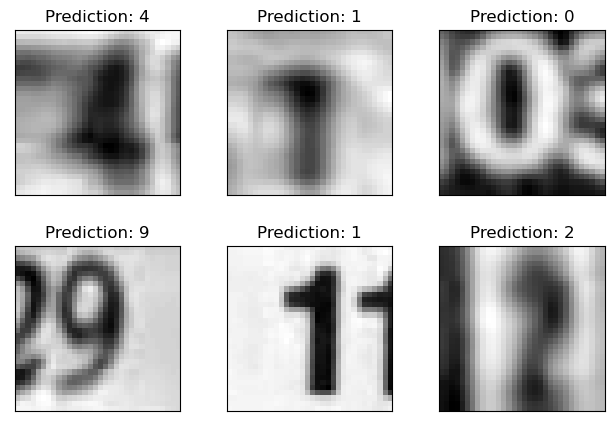

In [13]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig
plt.show()

### Ensembles

#### Setup

In [14]:
def create_bagging_dataloaders(data: DataLoader, n_estimators: int) -> List[DataLoader]:
    dataset = data.dataset
    dataloaders = []
    for i in range(n_estimators):
        # sampling with replacement
        indices = torch.randint(
            high=len(dataset), size=(len(dataset),), dtype=torch.int64
        )
        sub_dataset = Subset(dataset, indices)
        dataloader = DataLoader(
            sub_dataset,
            batch_size=data.batch_size,
            num_workers=data.num_workers,
            collate_fn=data.collate_fn,
            shuffle=True,
        )
        dataloaders.append(dataloader)
    return dataloaders

In [15]:
def create_estimators(n_estimators: int) -> List[nn.Module]:
    nets = []
    for i in range(n_estimators):
        net = Net()
        nets.append(net)
    return nets

In [16]:
def train_ensembles_bagging(train_dataloaders: List[DataLoader], estimators: List[nn.Module]):
    for b in range(len(estimators)):
        estimator = estimators[b]
        train_data_loader = train_dataloaders[b]
        optimizer = optim.SGD(estimator.parameters(), lr=learning_rate, momentum=momentum)
        for e in range(n_epochs):
            train(estimator, optimizer, e, train_data_loader)
            test(estimator, test_loader)

In [68]:
def validate_ensembles(estimators: List[nn.Module], train_dataloader: DataLoader, test_dataloader: DataLoader) -> Tuple:
    va_correct = 0
    va_loss = 0

    tr_correct = 0
    tr_loss = 0

    with torch.no_grad():
        
        for data, target in test_dataloader:
            outputs = []
            for estimator in estimators:
                estimator.eval()
                outputs.append(estimator(data).data.max(1, keepdim=True)[1])
            probs = torch.mean(torch.Tensor(outputs))
            pred = torch.max(probs, 1)
            va_loss += F.nll_loss(probs, target, size_average=False).item()
            va_correct += pred.eq(target.data.view_as(pred)).sum()
        
        for data, target in train_dataloader:
            outputs = []
            for estimator in estimators:
                estimator.eval()
                outputs.append(estimator(data).data.max(1, keepdim=True)[1])
            probs = torch.mean(torch.Tensor(outputs))
            pred = torch.max(probs, 1)
            tr_loss += F.nll_loss(probs, target, size_average=False).item()
            tr_correct += pred.eq(target.data.view_as(pred)).sum()

    va_accuracy = va_correct / len(test_dataloader.dataset)
    va_loss /= len(test_dataloader.dataset)

    tr_accuracy = tr_correct / len(train_dataloader.dataset)
    tr_loss /= len(train_dataloader.dataset)

    return (va_accuracy, va_loss, tr_accuracy, tr_loss)

#### Training

In [17]:
n_estimators = 15

In [18]:
### test with small data
train_dataloaders = create_bagging_dataloaders(train_loader, n_estimators)
estimators = create_estimators(n_estimators)
train_ensembles_bagging(train_dataloaders, estimators)


C:\Users\nawor\AppData\Local\Temp\ipykernel_31424\607711756.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 0 [0/73257 (0%)]	Loss: 2.299516
Train Epoch: 0 [640/73257 (1%)]	Loss: 2.294462
Train Epoch: 0 [1280/73257 (2%)]	Loss: 2.278095
Train Epoch: 0 [1920/73257 (3%)]	Loss: 2.276794
Train Epoch: 0 [2560/73257 (3%)]	Loss: 2.273086
Train Epoch: 0 [3200/73257 (4%)]	Loss: 2.269866
Train Epoch: 0 [3840/73257 (5%)]	Loss: 2.220115
Train Epoch: 0 [4480/73257 (6%)]	Loss: 2.215953
Train Epoch: 0 [5120/73257 (7%)]	Loss: 2.270117
Train Epoch: 0 [5760/73257 (8%)]	Loss: 2.228892
Train Epoch: 0 [6400/73257 (9%)]	Loss: 2.190680
Train Epoch: 0 [7040/73257 (10%)]	Loss: 2.192750
Train Epoch: 0 [7680/73257 (10%)]	Loss: 2.237094
Train Epoch: 0 [8320/73257 (11%)]	Loss: 2.286549
Train Epoch: 0 [8960/73257 (12%)]	Loss: 2.240973
Train Epoch: 0 [9600/73257 (13%)]	Loss: 2.166756
Train Epoch: 0 [10240/73257 (14%)]	Loss: 2.291487
Train Epoch: 0 [10880/73257 (15%)]	Loss: 2.258246
Train Epoch: 0 [11520/73257 (16%)]	Loss: 2.259586
Train Epoch: 0 [12160/73257 (17%)]	Loss: 2.175014
Train Epoch: 0 [12800/73257 (17

In [19]:
for i, model in enumerate(estimators):
    torch.save(model.state_dict(), f"model_{i}_state_dict.pth")

In [27]:
test_load_model = Net()
test_load_model.load_state_dict(torch.load("model_0_state_dict.pth"))
test_load_model.eval()
print(test_load_model(example_data))

tensor([[2.0143e-05, 6.1982e-04, 5.2466e-03,  ..., 1.0664e-04, 1.9371e-05,
         2.2776e-05],
        [1.7446e-02, 4.0056e-01, 3.5885e-02,  ..., 4.4749e-01, 1.5806e-02,
         1.2124e-02],
        [9.5170e-01, 7.8559e-04, 4.2810e-04,  ..., 5.2349e-06, 2.6195e-03,
         3.8697e-02],
        ...,
        [2.8994e-13, 2.3174e-10, 1.0000e+00,  ..., 1.7355e-07, 5.1237e-08,
         4.5306e-06],
        [1.7569e-03, 1.1557e-04, 6.6332e-03,  ..., 1.2778e-04, 1.4300e-02,
         9.5960e-01],
        [1.9415e-06, 8.4696e-09, 5.5799e-10,  ..., 9.1200e-08, 6.4797e-04,
         9.7631e-08]], grad_fn=<SoftmaxBackward0>)


C:\Users\nawor\AppData\Local\Temp\ipykernel_31424\607711756.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
C:\Users\nawor\AppData\Local\Temp\ipykernel_31424\1511957416.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(test_load_model(example_data)))


In [21]:
va_accuracy, va_loss, tr_accuracy, tr_loss = validate_ensembles(estimators, small_train_loader, small_test_loader)

NameError: name 'validate_ensembles' is not defined